In [1]:
import json
import jsondiff
import numpy as np
import matplotlib.pyplot as plt
import smopy
from numpy.random import default_rng
import scipy.stats
from scipy.spatial import distance

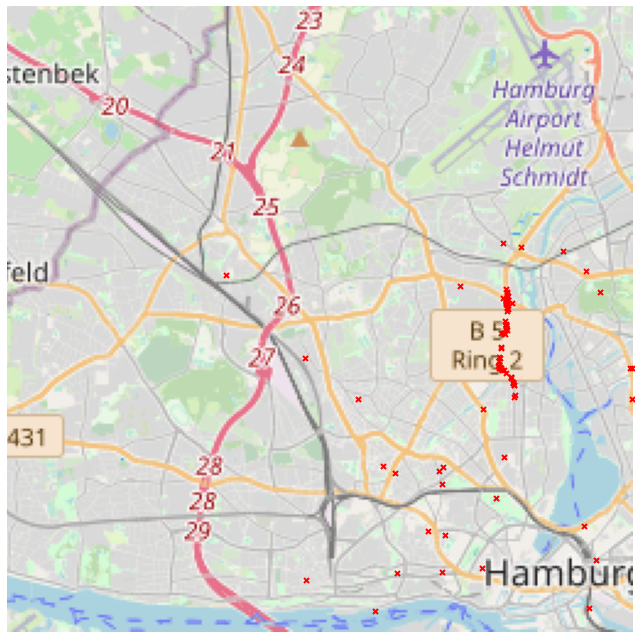

In [2]:
def extract_json_positions(data):
    '''
    Extract position tuples (latitude, longitude) from critical maps json.
    
    Parameters:
    data : dictonary
        json dictonary from critical maps website with n
        (longitude, latitude) tuples
    Returns:
    positions : numpy 2xn array
    '''
    locations = data['locations']
    positions = np.empty((0,2));
    for ident in locations:
        loc = locations[ident]
        positions=np.append(positions,[[loc['latitude']*1e-6,loc['longitude']*1e-6]],axis=0)
    return positions

def open_cm_log(path):
    ''' Open logged json in path, return json'''
    with open(path,'r') as f:
        data = json.load(f);
    return data
def distance_per_pixel(latitude,zoomlevel):
    ''' Calculate horizontal distance of each pixel for a given zoomlevel at a specific latitude (in degrees) '''
    C = 40075016.686; # Equotrial circumference of the earth
    return C*np.cos(latitude*np.pi/180)/2**(zoomlevel+8)

data = open_cm_log('cm_logs/20220624_202509.txt')
positions = extract_json_positions(data)
#mapHH = smopy.Map((53.55, 9.92, 53.6, 10.03), z=12)
#mapHH = smopy.Map((53.55, 9.94, 53.60, 9.97), z=12)
latitude = 53.585
mapHH = smopy.Map(latitude, 9.9817, z=11)
mapHH_z14 = smopy.Map(latitude, 9.9817, z=14)
positions_px_x,positions_px_y = mapHH.to_pixels(positions[:,0],positions[:,1])
px_scale = distance_per_pixel(latitude, mapHH.z)
ax = mapHH.show_mpl(figsize=(12, 9))
ylim = np.array(ax.get_ylim())
ylim_m = ylim*px_scale
xlim = np.array(ax.get_xlim())
xlim_m = xlim*px_scale
ax.plot(positions_px_x,positions_px_y, 'xr', ms=5, mew=2);

In [3]:
#https://www.ipol.im/pub/art/2017/176/article.pdf
# An Unsupervised Algorithm for Detecting Good Continuation in Dot Patterns, Lezama et al.
b = 5 # number of nearest neighbours used for exploration, default in paper: 5
lam = 4 # porportion of the local window radius w.r.t. the triplet size, default in paper: 4
delta = 10*256/256 # minimum discrete precision of the domain
pos = [np.array([x*px_scale,y*px_scale]) for x,y in zip(positions_px_x,positions_px_y)]
pos = [p for p in pos if (min(xlim_m) <= p[0] <= max(xlim_m)) and
                                  (min(ylim_m) <= p[1] <= max(ylim_m))]
pos_np = np.array(pos)
# Calculate distance maps
# https://stackoverflow.com/questions/48312205/find-the-k-nearest-neighbours-of-a-point-in-3d-space-with-python-numpy
D = distance.squareform(distance.pdist(pos))
N = len(pos)
closest = np.argsort(D, axis=1) #each line represents closest point indices

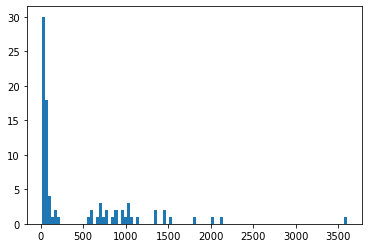

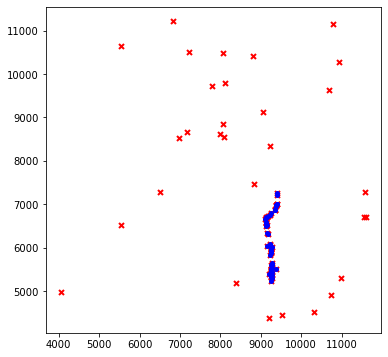

In [4]:
crit = np.mean(np.sort(D,axis=1)[:,1:5],axis=1)
counts,edges = np.histogram(crit,bins=101)
plt.stairs(counts,edges,fill=True)
plt.show()
plt.figure(figsize=(6,6))
selec = crit<4*np.median(crit)
plt.plot(pos_np[:,0],pos_np[:,1], 'xr', ms=5, mew=2);
plt.plot(pos_np[selec,0],pos_np[selec,1], 'ob', ms=3, mew=2);
pos_selec = pos_np[selec,:]
D_selec = distance.squareform(distance.pdist(pos_selec))
N_selec = len(pos_selec)
closest_selec = np.argsort(D_selec, axis=1) #each line represents closest point indices

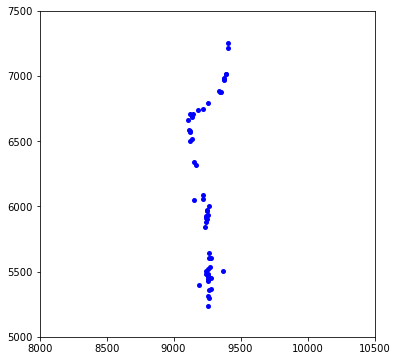

In [5]:
plt.figure(figsize=(6,6))
plt.plot(pos_selec[:,0],pos_selec[:,1], 'ob', ms=3, mew=2);
plt.ylim(5e3,7.5e3);
plt.xlim(8e3,10.5e3);

Notes:
https://stackoverflow.com/questions/61143998/numpy-best-fit-line-with-outliers
file:///C:/Users/Hauke/Downloads/AlgorithmsNotesForProfessionals.pdf
https://favtutor.com/blogs/floyd-warshall-algorithm

http://www.ipol.im/pub/art/2019/234/article.pdf
https://www.ipol.im/pub/art/2017/176/article.pdf

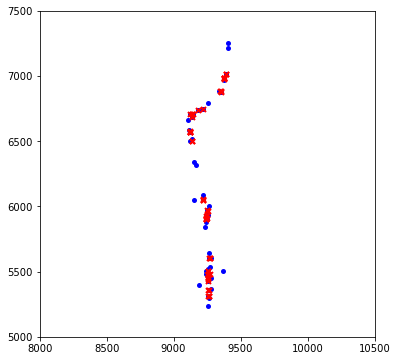

In [19]:
# Do some averaging to get rid of small outliers (people blocking traffic)
n=3
pos_selec_avg = np.copy(pos_selec)
for ii in range(N_selec):
    pos_selec_avg[ii,:] = np.median(pos_selec[closest_selec[ii,1:n+1],:],axis=0)
plt.figure(figsize=(6,6))
plt.plot(pos_selec[:,0],pos_selec[:,1], 'ob', ms=3, mew=2);
plt.plot(pos_selec_avg[:,0],pos_selec_avg[:,1], 'xr', ms=5, mew=2);
plt.ylim(5e3,7.5e3);
plt.xlim(8e3,10.5e3);

30 [9260.27896358 5314.53328295]


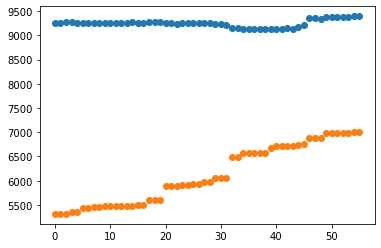

In [20]:
# 1. Sorting points
def sort_points(points):
    sorted_points = []
    sorted_mark = np.array(np.zeros(np.size(points,0)),dtype=bool)
    sorted_points = np.empty(np.shape(points))
    sorted_points[:] = np.nan
    jj = 0
    # Select first point
    first_point = np.argmin(points[:,1])
    print(first_point,points[first_point,:])
    sorted_points[jj,:] = points[first_point,:]
    #Mark first point as sorted
    sorted_mark[first_point] = True
    while not np.all(sorted_mark):
        #print(jj)
        cp = sorted_points[jj,:]
        unsorted_points = points.copy()
        unsorted_points[sorted_mark,:] = [np.nan,np.nan]
        d = np.sqrt((unsorted_points[:,0]-cp[0])**2 + (unsorted_points[:,1]-cp[1])**2)
        ii = np.nanargmin(d)
        jj = jj + 1
        sorted_points[jj,:] = unsorted_points[ii]
        sorted_mark[ii] = True
    return sorted_points
sorted_points = sort_points(pos_selec_avg)
plt.plot(sorted_points[:,0],'o')
plt.plot(sorted_points[:,1],'o')

#Roll array such that first element has minimum first coordinate
#roll_ii = np.argminb(sorted_points[:,0])
#print(roll_ii)
#sorted_points = np.roll(sorted_points,roll_ii,axis=0)

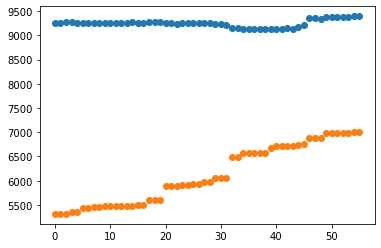

In [26]:
def find_starting_point(points):
    mindist = np.inf
    minidx = 0
    for i in range(len(points)):
        ordered = np.roll(points,i,axis=0)    # ordered nodes
        # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
        cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
        if cost < mindist:
            mindist = cost
            minidx = i
    return np.roll(points,minidx,axis=0)
c = find_starting_point(np.roll(sorted_points,2,axis=0))
plt.plot(c[:,0],'o')
plt.plot(c[:,1],'o')

In [8]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx

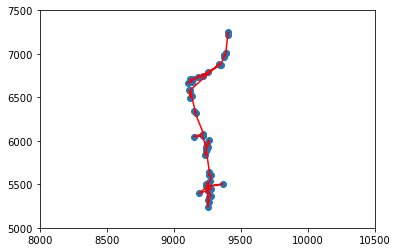

In [9]:
# 1. Sorting points, https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line
# Quite large n_neighbors to bridge larger gaps -> increases size of T matrix
clf = NearestNeighbors(n_neighbors=9).fit(pos_selec)
G = clf.kneighbors_graph(mode='distance')
T = nx.from_scipy_sparse_matrix(G)
order = list(nx.dfs_preorder_nodes(T, 38))
plt.figure()
plt.plot(pos_selec[:,0],pos_selec[:,1],'o')
plt.plot(pos_selec[order,0],pos_selec[order,1],'r-')
plt.ylim(5e3,7.5e3);
plt.xlim(8e3,10.5e3);

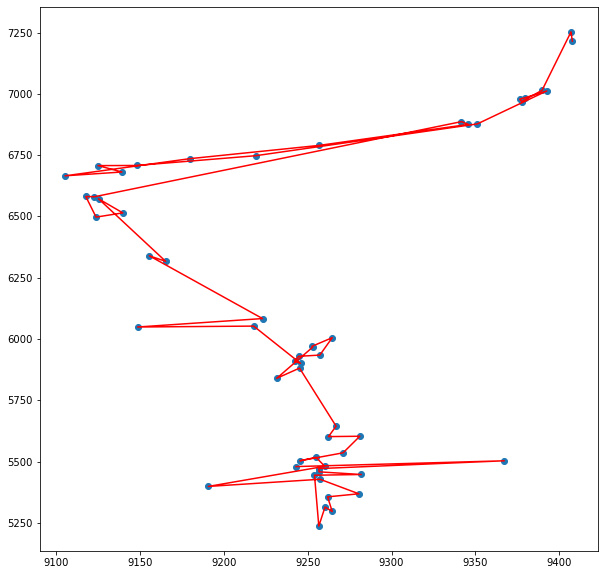

In [10]:
# Go through all starting points
paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(pos_selec))]
mindist = np.inf
minidx = 0
for i in range(len(pos_selec)):
    p = paths[i]           # order of nodes
    ordered = pos_selec[p]    # ordered nodes
    # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
    cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
    if cost < mindist:
        mindist = cost
        minidx = i
opt_order = paths[minidx]
plt.figure(figsize=(10,10))
plt.plot(pos_selec[:,0],pos_selec[:,1],'o')
plt.plot(pos_selec[opt_order,0],pos_selec[opt_order,1],'r-')
#plt.ylim(5e3,7.5e3);
#plt.xlim(8e3,10.5e3);

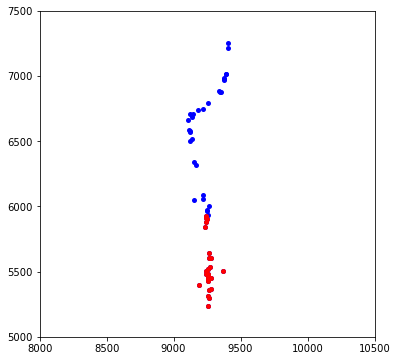

In [11]:
plt.figure(figsize=(6,6))
plt.plot(pos_selec[:,0],pos_selec[:,1], 'ob', ms=3, mew=2);
plt.plot(sorted_points[0:25,0],sorted_points[0:25,1], 'or', ms=3, mew=2);
plt.ylim(5e3,7.5e3);
plt.xlim(8e3,10.5e3);

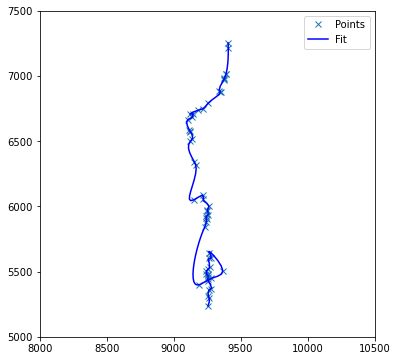

Length: 3158.194194182459


In [12]:
# 2. Fit sorted points
from scipy import interpolate
#https://scipy.github.io/devdocs/tutorial/interpolate.html
x,y = sorted_points[:,0],sorted_points[:,1]
tck, u = interpolate.splprep([x, y], s=100)
unew = np.arange(0, 1.01,0.01)
out = interpolate.splev(unew, tck)
plt.figure(figsize=(6,6))
plt.plot(x, y, 'x', out[0], out[1],'b')
plt.legend(['Points','Fit'])
plt.ylim(5e3,7.5e3);
plt.xlim(8e3,10.5e3);
plt.show()
# Calculate length
diffs = np.sqrt((out[0][:-1] - out[0][1:])**2 + (out[1][:-1] - out[1][1:])**2)
length = sum(diffs)
print('Length:', length)

In [13]:
len(u)

56

In [14]:
u = np.arange(len(y))
splines = [UnivariateSpline(u, coords, k=3, s=len(u)**2*10) for coords in sorted_points.T]
plt.plot(sorted_points[:,0],'o')
plt.plot(u,splines[0](u))
plt.show()
plt.plot(sorted_points[:,1],'o')
plt.plot(u,splines[1](u))

NameError: name 'UnivariateSpline' is not defined

In [ ]:
from sklearn.linear_model import HuberRegressor, LinearRegression
y= sorted_points[:,1]
u = np.arange(len(y))
X = u.reshape(-1,1)
huber = HuberRegressor().fit(X,y)
linear = LinearRegression().fit(X, y)
plt.scatter(u,y)
plt.plot(u, 
         huber.coef_ * u + huber.intercept_,
         color='red',linestyle='--')
plt.show()

In [ ]:
#https://stackoverflow.com/questions/52014197/how-to-interpolate-a-2d-curve-in-pythonimport
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline

# Define some points:
theta = np.linspace(-3, 2, 40)
points = np.vstack( (np.cos(theta), np.sin(theta)) ).T

# add some noise:
points = points + 0.25*np.random.randn(*points.shape)

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Build a list of the spline function, one for each dimension:
splines = [UnivariateSpline(distance, coords, k=3, s=5) for coords in points.T]

# Computed the spline for the asked distances:
alpha = np.linspace(0, 1, 75)
points_fitted = np.vstack( [spl(alpha) for spl in splines] ).T

# Graph:
plt.plot(*points.T, 'ok', label='original points');
plt.plot(*points_fitted.T, '-r', label='fitted spline k=3, s=.2');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');

In [ ]:
points.T